In [67]:
import datashader as ds
import datashader.transfer_functions as tf
import numpy as np
import pandas as pd
from IPython.core.display import HTML, display

In [68]:
data = pd.read_csv('../../data/processed/renaloc_geolocalized.csv' , encoding = "ISO-8859-1")

In [69]:
import pyproj

wgs84=pyproj.Proj("+init=EPSG:4326")
webmercator = pyproj.Proj("+init=EPSG:3857")

#data['meterswest'], data['metersnorth'] = pyproj.transform(wgs84, webmercator, list(data['longitude']) - np.mean(correc_long) , list(data['latitude']) - np.mean(correc_lat))

data['meterswest'], data['metersnorth'] = data['longitude']* 100000 , data['latitude'] * 100000

In [70]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [71]:
background = "black"
plot_width  = int(1000)
plot_height = int(plot_width*7.0/12)

Niger = ((20400,  1603000), (1309690, 2403810))
x_range,y_range = Niger

In [72]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

In [73]:
cvs = ds.Canvas(plot_width, plot_height, *Niger)
agg = cvs.points(data, 'meterswest', 'metersnorth')

In [74]:
if background == "black":
      color_key = {'H':'aqua', 'VA':'lime' , 'CPT':'red', 'PE':'fuchsia', 'QT':'yellow' }
else: color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange',  'o':'saddlebrown'}

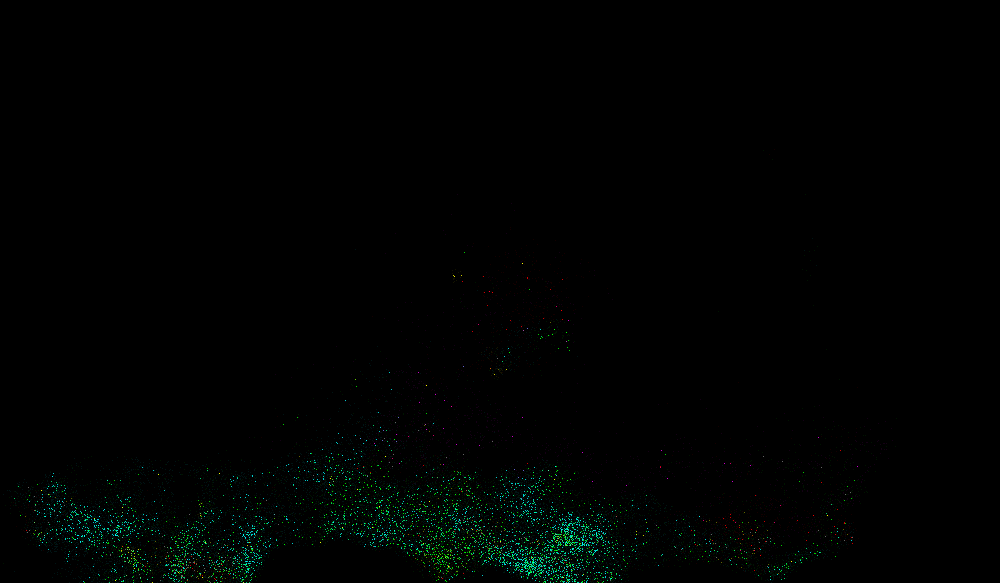

In [78]:
def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(data, 'meterswest', 'metersnorth', ds.count_cat('settlement_type'))
    img = tf.colorize(agg, color_key, how='eq_hist')
    return img

data.settlement_type = data.settlement_type.astype('category')

export(create_image(*Niger),"Test")

In [76]:
#export(tf.interpolate(agg, cmap = cm(Hot,0.2), how='eq_hist'),"census_ds_hot_eq_hist")

In [77]:
from bokeh.models.tiles import WMTSTileSource
from datashader.callbacks import InteractiveImage
from bokeh.plotting import figure, output_file, show, ColumnDataSource, output_notebook
from bokeh.models import HoverTool

output_notebook()

def base_plot(tools='pan,wheel_zoom,reset',webgl=False):
    hover = HoverTool( tooltips= [
            ("(x,y)", "($x, $y)"),
            ("name", "@name"),
            ("population", "@population"),
        ])
    p = figure(tools=[tools,hover],
        plot_width=int(900*1.5), plot_height=int(500*1.5),
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, webgl=webgl)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    return p

Loading BokehJS ...

In [83]:
from datashader.callbacks import InteractiveImage

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(data, 'meterswest', 'metersnorth', ds.count_cat('settlement_type'))
    img = tf.colorize(agg, color_key, 'log')
    return tf.dynspread(img,threshold=0.75, max_px=8)

p = base_plot()

url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png"
#url="http://tile.stamen.com/toner-background/{Z}/{X}/{Y}.png"
p.yaxis.major_label_orientation = 'vertical'
tile_renderer = p.add_tile(WMTSTileSource(url=url))
tile_renderer.alpha=1 if background == "black" else 0.15

InteractiveImage(p, image_callback)

AttributeError: 'tuple' object has no attribute 'yaxis'